In [1]:
import sys
print(sys.path)

['', '/usr/lib/python35.zip', '/usr/lib/python3.5', '/usr/lib/python3.5/plat-x86_64-linux-gnu', '/usr/lib/python3.5/lib-dynload', '/home/hao/.local/lib/python3.5/site-packages', '/usr/local/lib/python3.5/dist-packages', '/usr/lib/python3/dist-packages', '/home/hao/.local/lib/python3.5/site-packages/IPython/extensions', '/home/hao/.ipython']


In [2]:
import cv2
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, SpatialDropout2D, ELU
from keras.layers import Conv2D, MaxPooling2D, Cropping2D
from keras.layers.core import Lambda

from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras.regularizers import l2

from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

Using TensorFlow backend.


# Data Import

In [3]:
import os
import csv

reduced = False

if reduced == True:
    csv_filepath = 'driving_log_reduced.csv'
else:
    csv_filepath = 'driving_log.csv'
samples = []
with open(csv_filepath) as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        speed = line[6]
        if float(speed)>15:
            samples.append(line)
        
def add_to_samples(csv_filepath, samples):
    with open(csv_filepath) as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            speed = line[6]
            if float(speed)>15:
                samples.append(line)
    return samples

samples = add_to_samples('driving_log_2.csv', samples)
# samples = add_to_samples('driving_log_3.csv', samples)
# samples = add_to_samples('driving_log_4.csv', samples)
print(len(samples))

32909


In [4]:
image_paths=[]
angles = []
for line in samples:
    image_paths.append(line[0])
    angles.append(float(line[3]))
image_paths = np.array(image_paths)
angles = np.array(angles)
# angles = running_mean_full(angles)

print('Before:', image_paths.shape[0], angles.shape[0])

Before: 32909 32909


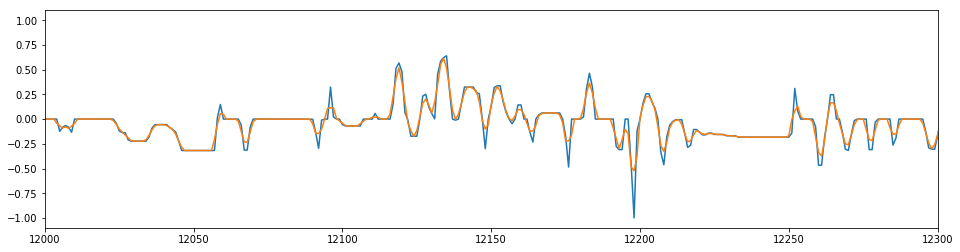

In [5]:
def running_mean_full(x, N=3):
    return np.convolve(x, np.ones((N,))/N, 'same')

plt.figure(figsize=(16,4))
plt.xlim(12000,12300)
plt.plot(angles)
plt.plot(running_mean_full(angles))

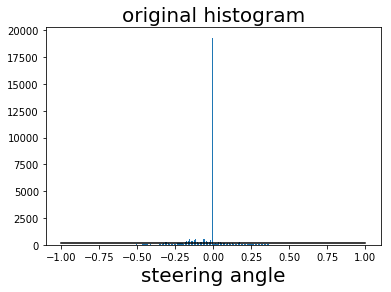

target is : 164.545


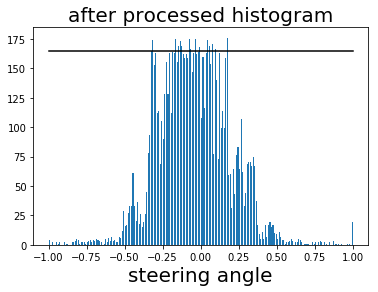

After: 9647 9647
Samples:  9647


In [6]:
# print a histogram to see which steering angle ranges are most overrepresented
plt.figure
num_bins = 200
avg_samples_per_bin = len(angles)/num_bins
hist, bins = np.histogram(angles, num_bins)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.plot((np.min(angles), np.max(angles)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')
plt.title('original histogram', fontsize=20)
plt.xlabel('steering angle', fontsize=20)
plt.show()

# determine keep probability for each bin: if below avg_samples_per_bin, keep all; otherwise keep prob is proportional
# to number of samples above the average, so as to bring the number of samples for that bin down to the average
keep_probs = []
target = avg_samples_per_bin
# target = avg_samples_per_bin * 0.5
print("target is :", target)
for i in range(num_bins):
    if hist[i] < target:
        keep_probs.append(1.0)
    else:
        keep_probs.append(1.0/(hist[i]/target))
remove_list = []

for i in range(len(angles)):
    for j in range(num_bins):
        if angles[i] >= bins[j] and angles[i] < bins[j+1]:
            # delete from X and y with probability 1 - keep_probs[j]
            if np.random.rand() > keep_probs[j]:
                remove_list.append(i)
image_paths = np.delete(image_paths, remove_list, axis=0)
angles = np.delete(angles, remove_list)
samples = np.delete(samples, remove_list, axis=0)
# balanced_samples = [v for i, v in enumerate(samples) if i not in del_ind]

# print histogram again to show more even distribution of steering angles
plt.figure
hist, bins = np.histogram(angles, num_bins)
plt.bar(center, hist, align='center', width=width)
plt.plot((np.min(angles), np.max(angles)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')
plt.title('after processed histogram', fontsize=20)
plt.xlabel('steering angle', fontsize=20)
plt.show()

print('After:', image_paths.shape[0], angles.shape[0])
print('Samples: ', len(samples))

In [7]:
def balance_data(samples, visulization_flag ,N=100, K=40,  bins=100):
    """ Crop the top part of the steering angle histogram, by removing some images belong to those steering angels

    :param images: images arrays
    :param angles: angles arrays 
    :param n:  The values of the histogram bins
    :param bins: The edges of the bins. Length nbins + 1
    :param K: maximum number of max bins to be cropped
    :param N: the max number of the images which will be used for the bin
    :return: images, angle
    """

    angles = []
    for line in samples:
        angles.append(float(line[3]))

    n, bins, patches = plt.hist(angles, bins=bins, color= 'orange', linewidth=0.1)
    angles = np.array(angles)
    n = np.array(n)

    idx = n.argsort()[-K:][::-1]    # find the largest K bins
    del_ind = []                    # collect the index which will be removed from the data
    for i in range(K):
        if n[idx[i]] > N:
            ind = np.where((bins[idx[i]]<=angles) & (angles<bins[idx[i]+1]))
            ind = np.ravel(ind)
            np.random.shuffle(ind)
            del_ind.extend(ind[:len(ind)-N])

    # angles = np.delete(angles,del_ind)
    balanced_samples = [v for i, v in enumerate(samples) if i not in del_ind]
    balanced_angles = np.delete(angles,del_ind)


#     plt.clf()
    plt.close() # clear the histogram figure above
    
    if visulization_flag:
        plt.figure(figsize=(12,6))
        plt.subplot(1,2,1)
        n, bins, patches = plt.hist(angles, bins=bins, color='orange', linewidth=0.1)
        plt.title('origin histogram', fontsize=20)
        plt.xlabel('steering angle', fontsize=20)
        plt.ylabel('counts', fontsize=20)
        
        plt.subplot(1,2,2)
        plt.hist(balanced_angles, bins=bins, color= 'orange', linewidth=0.1)
        plt.title('modified histogram', fontsize=20)
        plt.xlabel('steering angle', fontsize=20)
        plt.ylabel('counts', fontsize=20)
        
        plt.show()

        plt.figure(figsize=(12,6))
        aa = np.append(balanced_angles, -balanced_angles)
        bb = np.append(aa, aa)
        plt.hist(bb, bins=bins, color='orange', linewidth=0.1)
        plt.title('final histogram', fontsize=20)
        plt.xlabel('steering angle', fontsize=20)
        plt.ylabel('counts', fontsize=20)
        plt.show()

    return balanced_samples

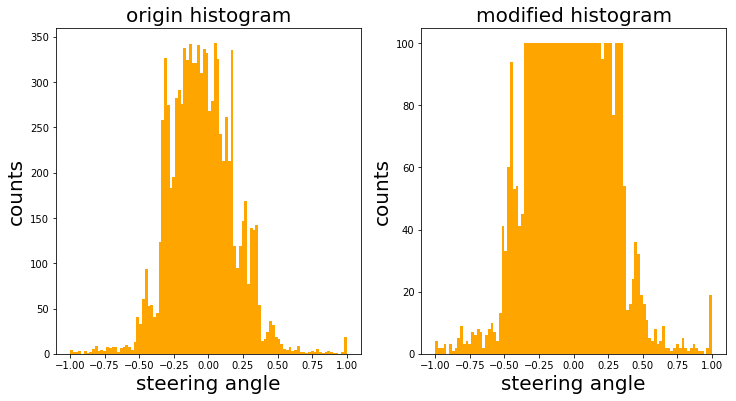

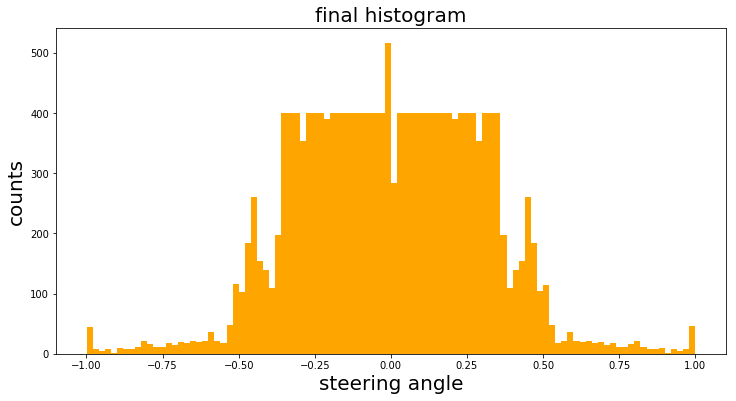

Samples:  4417


In [8]:
# balance the data with smooth the histogram of steering angles
samples = balance_data(samples, visulization_flag=True)
print("Samples: ", len(samples)) 

In [9]:
#samples = samples[1:]
print("Samples: ", len(samples))    
from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.3)

Samples:  4417


In [10]:
new_size_col = 200
new_size_row = 66

def cropImage(image):
    # Preprocessing image files
    shape = image.shape
    # note: numpy arrays are (row, col)!
    image = image[60:shape[0]-20, 10:shape[1]-10]   
    return image

def resizeImage(image):
    # Preprocessing image files
    shape = image.shape
#     image = cv2.resize(image,(new_size_col,new_size_row))
    image = cv2.resize(image,(new_size_col,new_size_row), interpolation=cv2.INTER_AREA)   
    return image

def convert2YUV(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    return image

def preprocessImage(image):
    image = cropImage(image)
    image = resizeImage(image)
    return image

def brightness_change(image):
    """  change the brightness of the input image

    :param image: input image
    :return: new image
    """
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = np.random.uniform(0.2,0.5)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)

    return image1

def add_random_shadow(image):
    row, col, chan = image.shape
    top_y = col*np.random.uniform()
    top_x = 0
    bot_x = row
    bot_y = col*np.random.uniform()
    image_hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    shadow_mask = 0*image_hls[:,:,1]
    X_m = np.mgrid[0:image.shape[0],0:image.shape[1]][0]
    Y_m = np.mgrid[0:image.shape[0],0:image.shape[1]][1]

    shadow_mask[((X_m-top_x)*(bot_y-top_y) -(bot_x - top_x)*(Y_m-top_y) >=0)]=1
    #random_bright = .25+.7*np.random.uniform()

    random_bright = 0.3
    cond1 = shadow_mask==1
    cond0 = shadow_mask==0
    if np.random.randint(2)==1:
        image_hls[:,:,1][cond1] = image_hls[:,:,1][cond1]*random_bright
    else:
        image_hls[:,:,1][cond0] = image_hls[:,:,1][cond0]*random_bright    
    image = cv2.cvtColor(image_hls,cv2.COLOR_HLS2RGB)
    return image


# def add_random_shadow(image):
#     image_hsv = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
#     bright_factor = 0.5
#     x = random.randint(0, image.shape[1])
#     y = random.randint(0, image.shape[0])

#     width = random.randint(int(image.shape[1]/2),image.shape[1])
#     if(x+ width > image.shape[1]):
#         x = image.shape[1] - x
#     height = random.randint(int(image.shape[0]/2),image.shape[0])
#     if(y + height > image.shape[0]):
#         y = image.shape[0] - y
#     image_hsv[y:y+height,x:x+width,2] = image_hsv[y:y+height,x:x+width,2]*bright_factor
#     image = cv2.cvtColor(image_hsv,cv2.COLOR_HSV2BGR)
#     return image


def trans_image(image,steer,trans_x, trans_y =0):
    """trans_range
    translate image and compensate for the translation on the steering angle
    work with original size image with 160*320 
    """
    
    rows, cols, chan = image.shape
    
    # horizontal translation with 0.008 steering compensation per pixel
    tr_x = trans_x*np.random.uniform()-trans_x/2
    steer_ang = steer + tr_x/trans_x*.4
    
    # option to disable vertical translation to 0 (vertical translation not necessary)
    tr_y = trans_y*np.random.uniform()-trans_y/2

    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image_tr = cv2.warpAffine(image,Trans_M,(cols,rows))

    return image_tr,steer_ang

In [11]:
def data_augmentation(images, angles):
    """ flip every image and change the blitheness of the image, then appended to the lists

    :param images: origin image
    :param angles: origin angles
    :return: added augmented images and their angles
    """
    
    augmented_images = []
    augmented_angles = []
    for image, angle in zip(images, angles):
        # preprocess image: crop and resize
        image = preprocessImage(image)
                
        augmented_images.append(image)
        augmented_angles.append(angle)
        
        # flip images 
        flipped_image = cv2.flip(image,1)
        flipped_angle = -1.0 * angle
        augmented_images.append(flipped_image)
        augmented_angles.append(flipped_angle)
        
        # add random shadow images
        shadowed_image = add_random_shadow(image)
        augmented_images.append(shadowed_image)
        augmented_angles.append(angle)
        shadowed_flipped_image = add_random_shadow(flipped_image)
        augmented_images.append(shadowed_flipped_image)
        augmented_angles.append(flipped_angle)
           
        # change brightness images
        image_b1 = brightness_change(image)
        image_b2 = brightness_change(flipped_image)
        augmented_images.append(image_b1)
        augmented_angles.append(angle)
        augmented_images.append(image_b2)
        augmented_angles.append(flipped_angle)
        
    # convert images to YUV color space
    augmented_images = [convert2YUV(image) for image in augmented_images]
    
    return augmented_images, augmented_angles

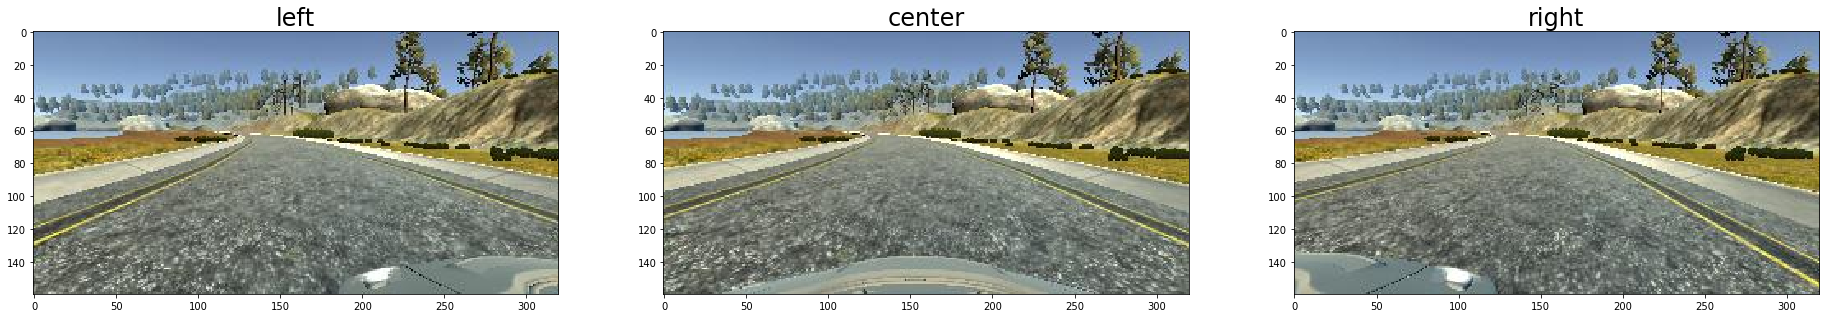

In [12]:
def plotCameraFrames(samples):
    shuffle(samples)
    num_samples = len(samples)    
    plot_index = random.randint(0, num_samples)
    sample = samples[plot_index]
    center = sample[0]
    left = sample[1].replace(" ", "")
    right = sample[2].replace(" ", "")
    center_image = mpimg.imread(center)
    left_image = mpimg.imread(left)
    right_image = mpimg.imread(right)

    plt.figure(figsize=(32,32))
    plt.subplots_adjust(hspace=.2)

    plt.subplot(1,3,1)
    plt.title('left', fontsize=24)
    plt.imshow(left_image)
    plt.subplot(1,3,2)
    plt.title('center', fontsize=24)
    plt.imshow(center_image)
    plt.subplot(1,3,3)
    plt.title('right', fontsize=24)
    plt.imshow(right_image)

plotCameraFrames(samples)

after crop image:  (80, 300, 3)
after resize image:  (66, 200, 3)


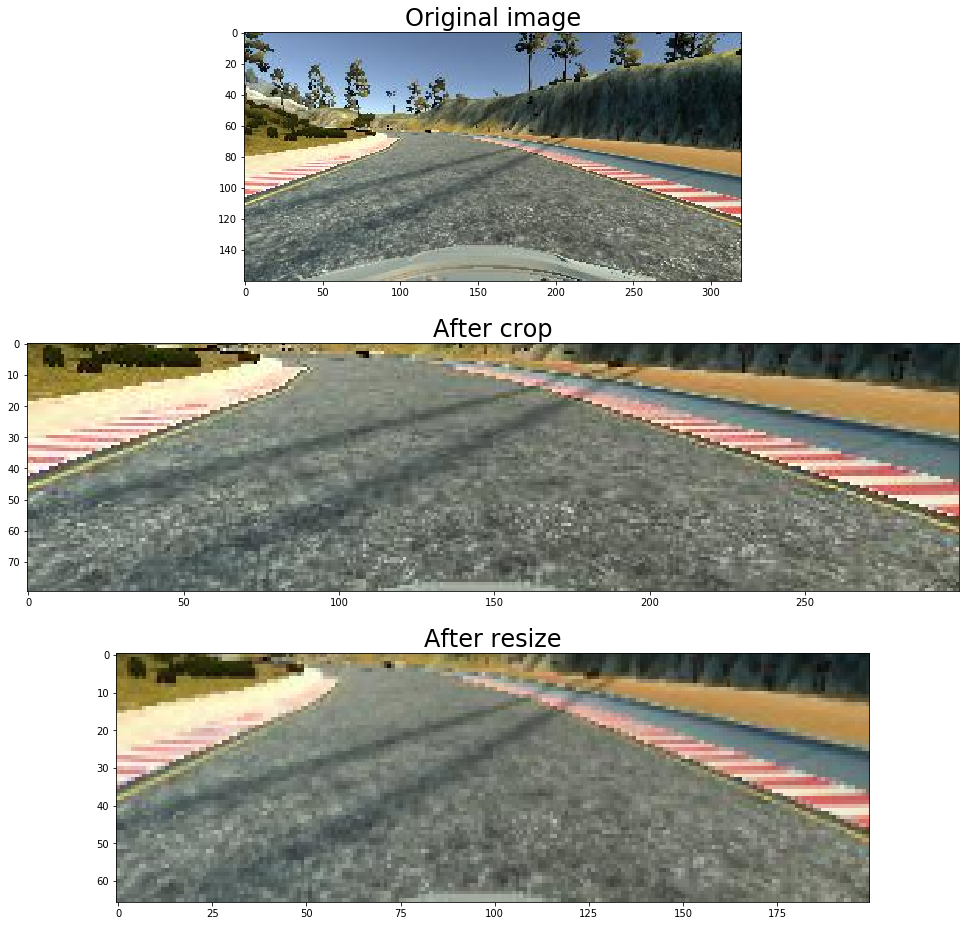

In [13]:
def plotPreprocess(samples):
    shuffle(samples)
    num_samples = len(samples)    
    plot_index = random.randint(0, num_samples)
    sample = samples[plot_index]
    name = sample[0]
    image = mpimg.imread(name)
#     image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    plt.figure(figsize=(32,16))
    plt.subplots_adjust(hspace=.25)

    image1 = cropImage(image)
    print('after crop image: ', image1.shape)
    image2 = resizeImage(image1)
    print('after resize image: ', image2.shape)
    plt.subplot(3,1,1)
    plt.title('Original image', fontsize=24)
    plt.imshow(image)
    plt.subplot(3,1,2)
    plt.title('After crop', fontsize=24)
    plt.imshow(image1)
    plt.subplot(3,1,3)
    plt.title('After resize', fontsize=24)
    plt.imshow(image2)

plotPreprocess(samples)

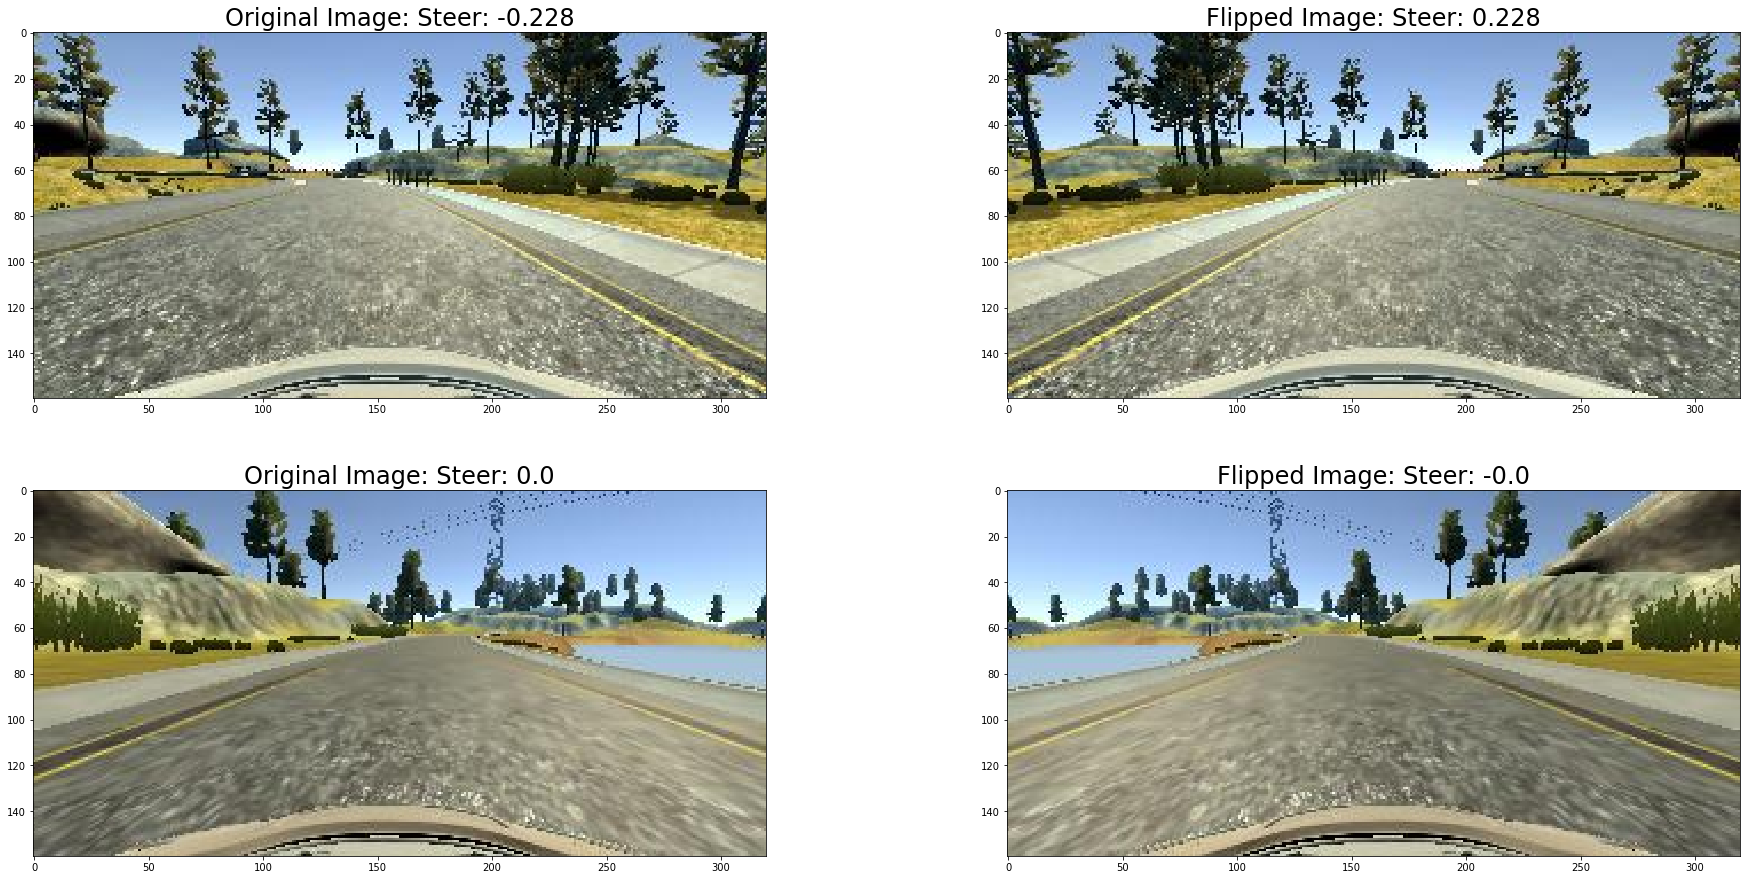

In [14]:
def plotFlip(samples):
    shuffle(samples)
    num_samples = len(samples)
    
    plt.figure(figsize=(32,32))
    plt.subplots_adjust(hspace=.25)
    for i in range(0, 4, 2):
        plot_index = random.randint(0, num_samples)
        sample = samples[plot_index]
        name = sample[0]
        angle = float(sample[3])
        image = mpimg.imread(name)
#         image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        
        plt.subplot(4,2,i+1)
        plt.title('Original Image: Steer: ' + str(np.round(angle,3)), fontsize=24)
        plt.imshow(image)
        
        image1 = cv2.flip(image, 1)
        plt.subplot(4,2,i+2)
        plt.title('Flipped Image: Steer: ' + str(np.round(-1*angle,3)), fontsize=24)
        plt.imshow(image1)
    
plotFlip(samples)

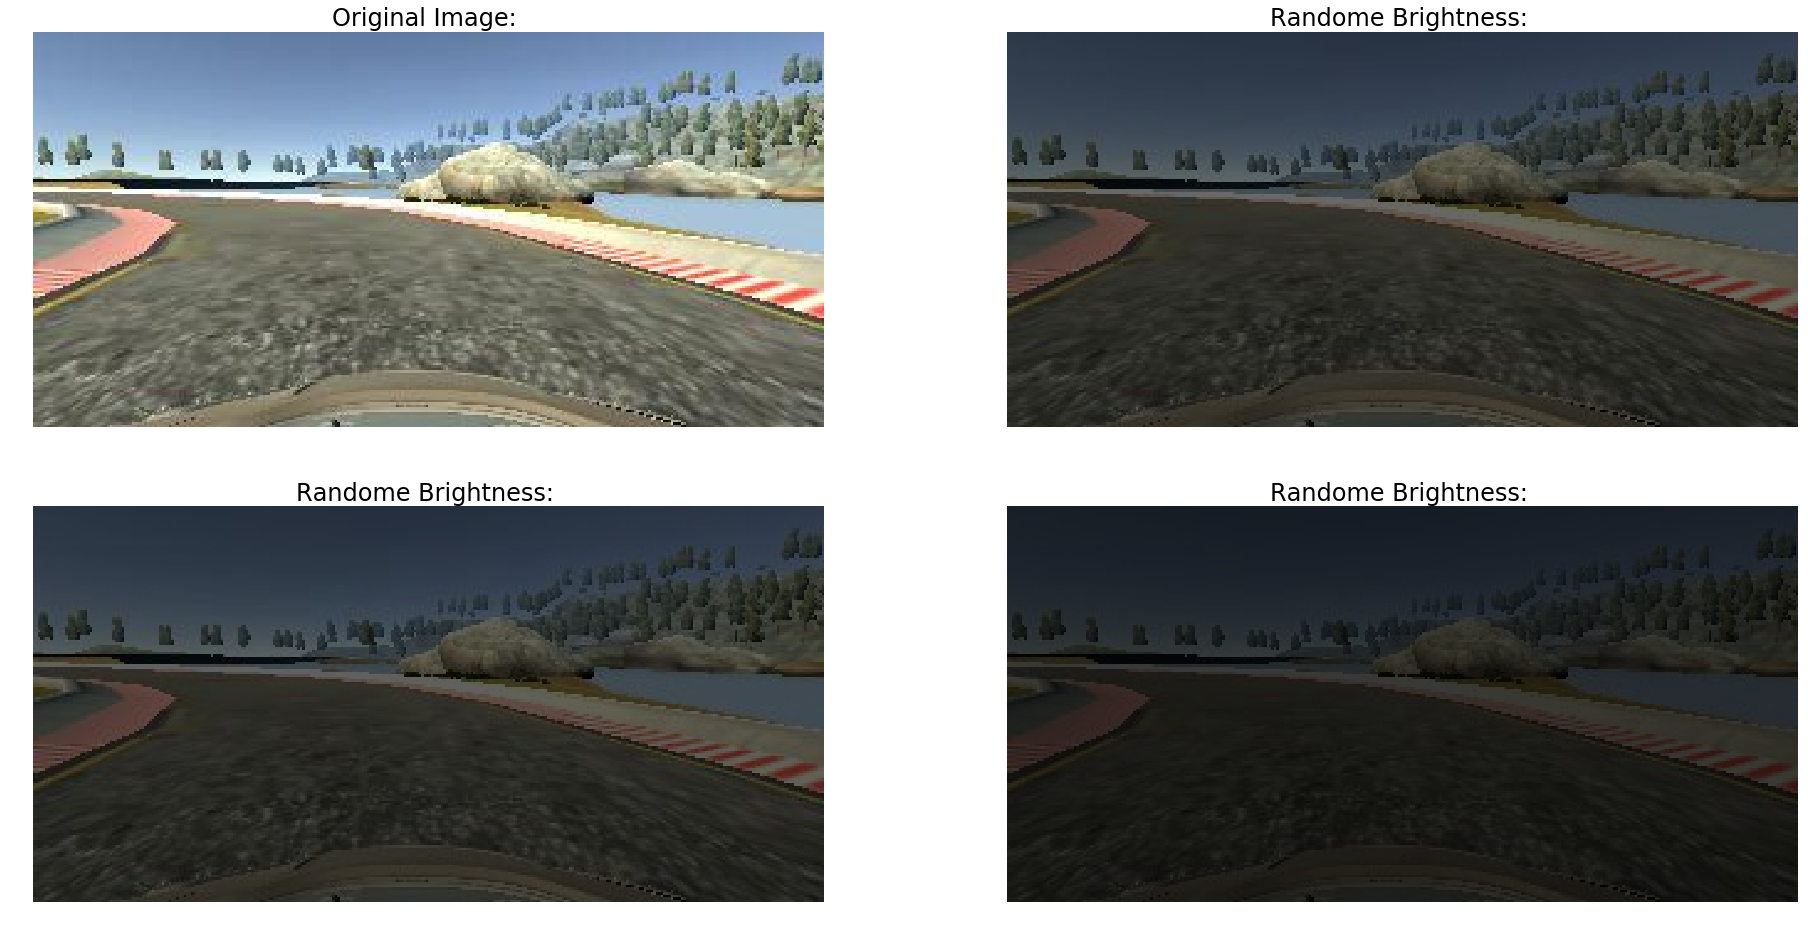

In [15]:
def plotBrightness(samples):
    shuffle(samples)
    num_samples = len(samples)
    
    plot_index = random.randint(0, num_samples)
    sample = samples[plot_index]
    name = sample[0]
    image = mpimg.imread(name)
#     image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    
    plt.figure(figsize=(32,16))
    
    plt.subplot(2,2,1)
    plt.title('Original Image: ', fontsize=24)
    plt.imshow(image)
    plt.axis('off')
    
    for i in range(3):               
        image1 = brightness_change(image)
        plt.subplot(2,2,i+2)
        plt.title('Randome Brightness: ', fontsize=24)
        plt.imshow(image1)
        plt.axis('off')

#     plt.figure(figsize=(32,16))
#     for i in range(4):
#         plot_index = random.randint(0, num_samples)
#         sample = samples[plot_index]
#         name = sample[0]
#         image = mpimg.imread(name)
# #         image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)

#         image1 = brightness_change(image)
#         plt.subplot(2,2,i+1)
#         plt.title('Brightness on RANDOM Images: ', fontsize=24)
#         plt.imshow(image1)
#         plt.axis('off')
plotBrightness(samples)

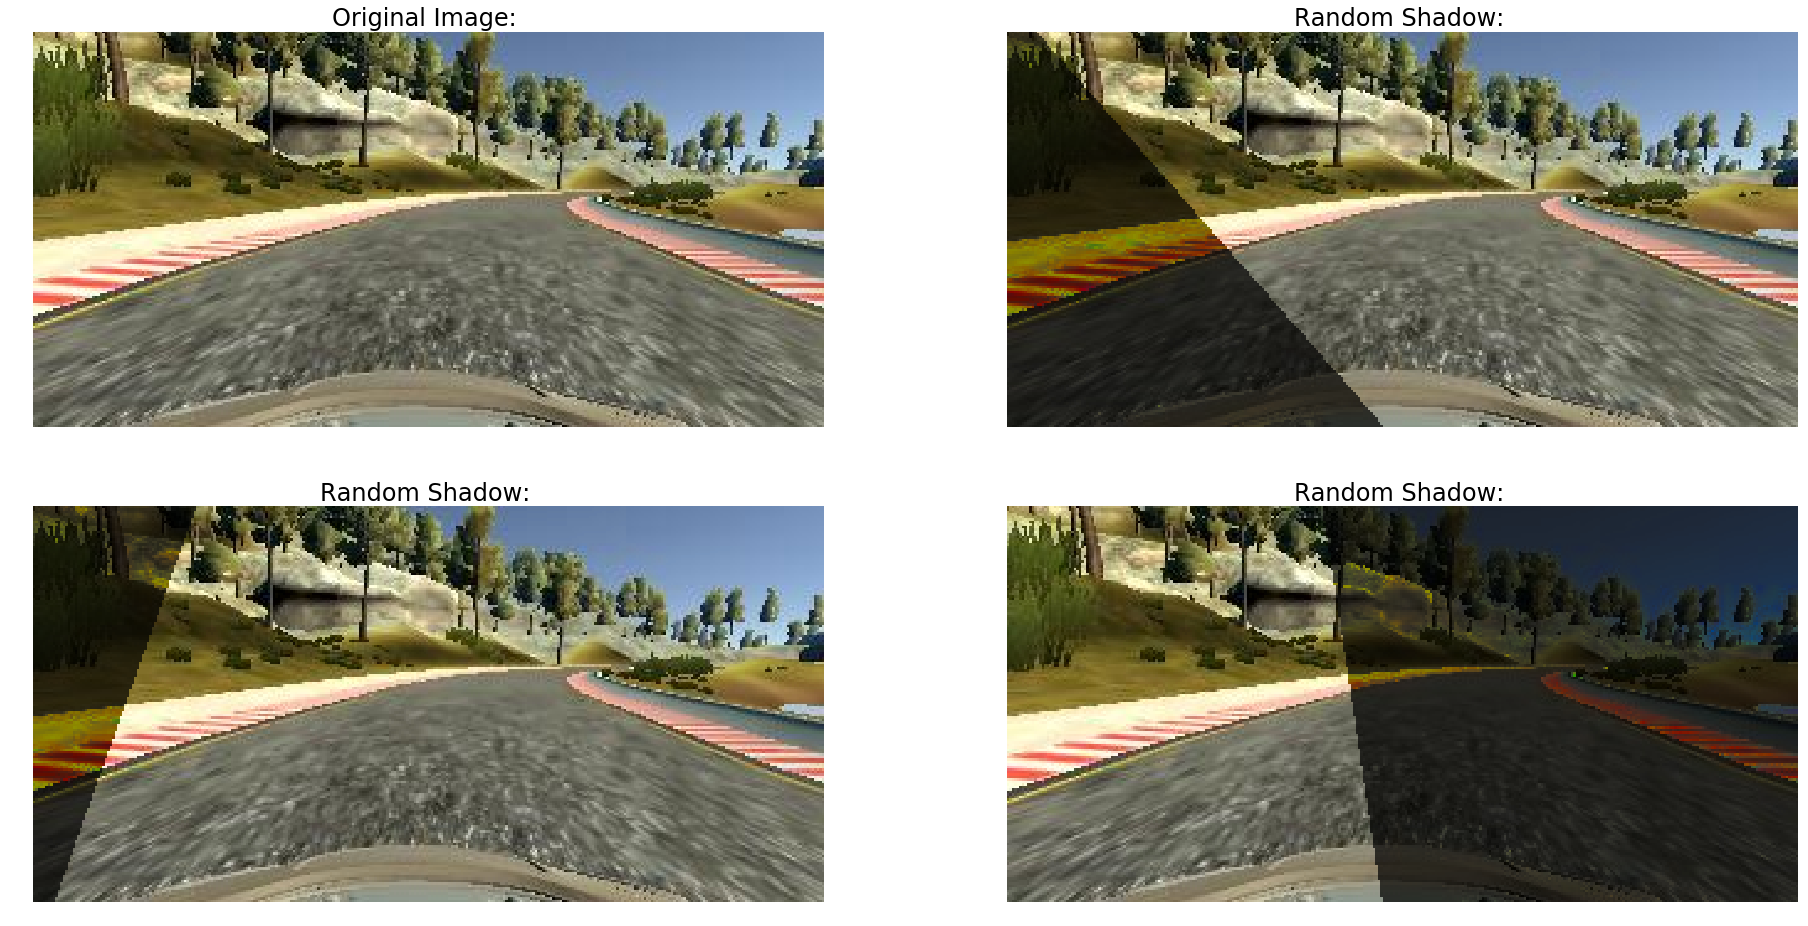

In [16]:
def plotShadow(samples):
    shuffle(samples)
    num_samples = len(samples)
    
    plot_index = random.randint(0, num_samples)
    sample = samples[plot_index]
    name = sample[0]
    image = mpimg.imread(name)

    plt.figure(figsize=(32,16))
    
    plt.subplot(2,2,1)
    plt.title('Original Image: ', fontsize=24)
    plt.imshow(image)
    plt.axis('off')
    
    for i in range(3):               
        image1 = add_random_shadow(image)
#         image1 = cv2.cvtColor(image1, cv2.COLOR_RGB2YUV)
        plt.subplot(2,2,i+2)
        plt.title('Random Shadow: ', fontsize=24)
        plt.imshow(image1)
        plt.axis('off')
        
#     plt.figure(figsize=(32,16))
#     for i in range(4):
#         plot_index = random.randint(0, num_samples)
#         sample = samples[plot_index]
#         name = sample[0]
#         image = mpimg.imread(name)
        

#         image1 = add_random_shadow(image)
# #         image1 = cv2.cvtColor(image1, cv2.COLOR_RGB2YUV)
#         plt.subplot(2,2,i+1)
#         plt.title('Shadow on RANDOM Images: ', fontsize=24)
#         plt.imshow(image1)
#         plt.axis('off')
        
plotShadow(samples)

Original angle is  0.2514528


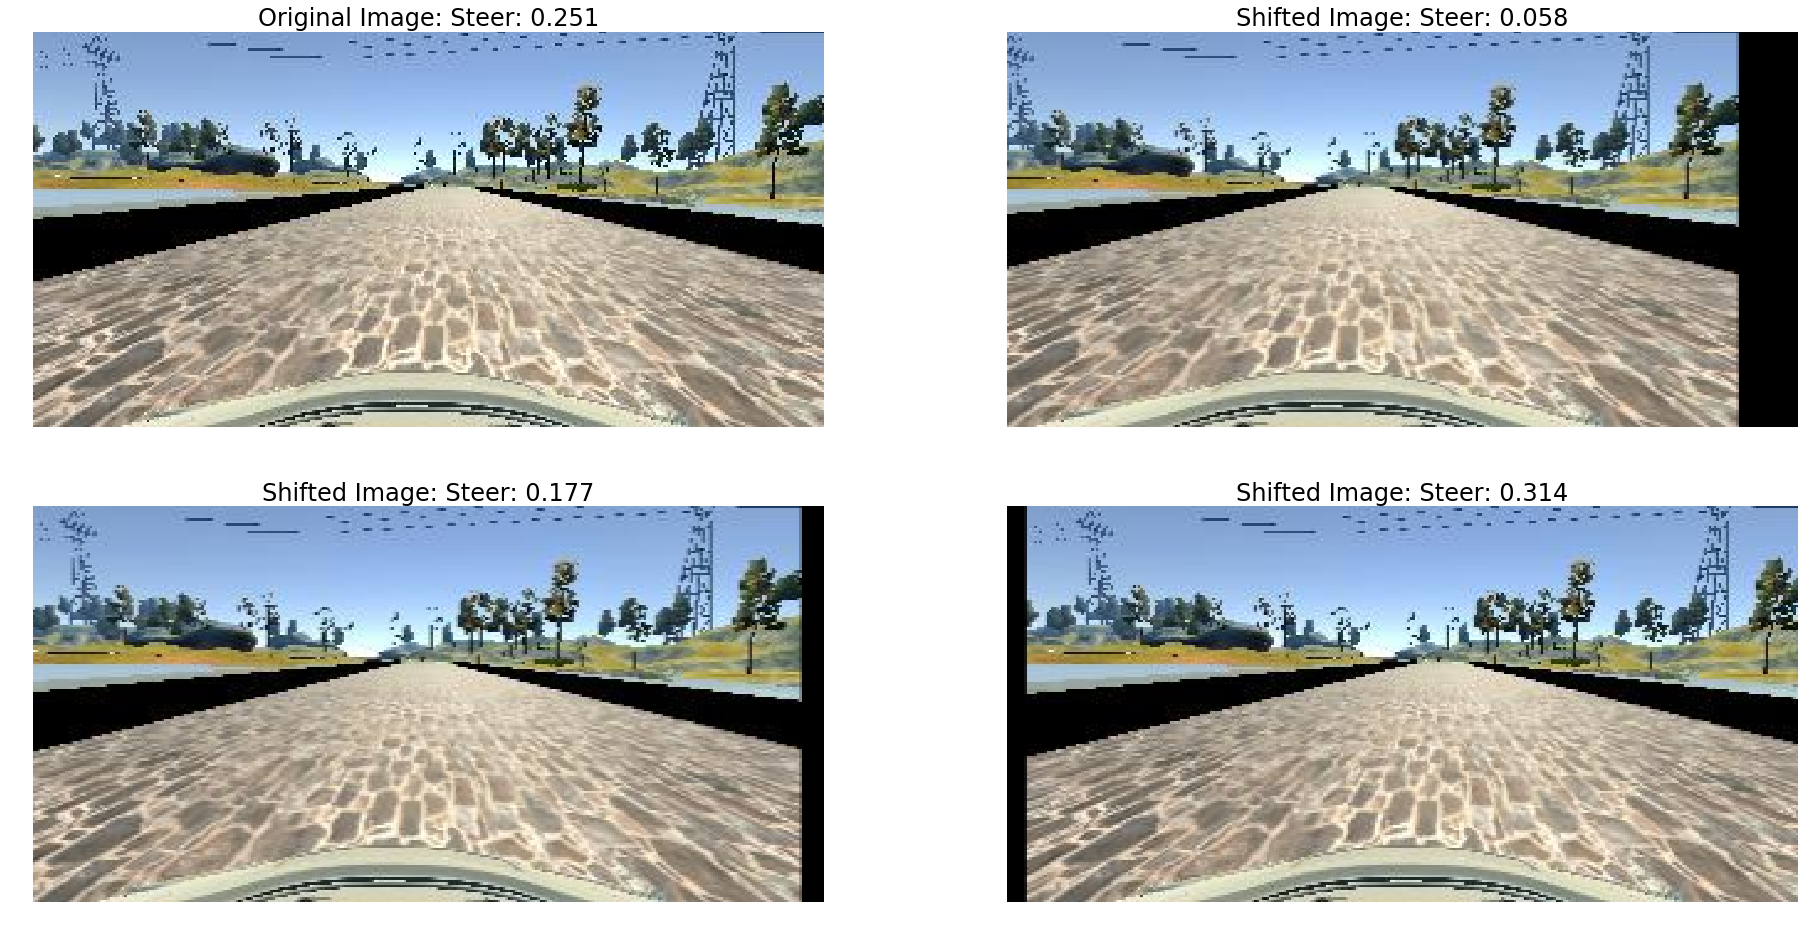

In [17]:
def plotTransImage(samples):
    shuffle(samples)
    num_samples = len(samples)
    
    plot_index = random.randint(0, num_samples)
    sample = samples[plot_index]
    name = sample[0]
    image = mpimg.imread(name)
#     image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)

    angle = float(sample[3])
    print('Original angle is ',angle)
    plt.figure(figsize=(32,16))
    
    plt.subplot(2,2,1)
    plt.title('Original Image: Steer: ' + str(np.round(angle, 3)), fontsize=24)
    plt.imshow(image)
    plt.axis('off')
    
    for i in range(3):               
        image1, angle1 = trans_image(image, angle, 50, 0)
        plt.subplot(2,2,i+2)
        plt.title('Shifted Image: Steer: ' + str(np.round(angle1, 3)), fontsize=24)
        plt.imshow(image1)
        plt.axis('off')
    
#     plt.figure(figsize=(32,16))
#     for i in range(4):
#         plot_index = random.randint(0, num_samples)
#         sample = samples[plot_index]
#         name = sample[0]
#         image = mpimg.imread(name)
# #         image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)

#         angle = float(sample[3])
#         image1, angle1 = trans_image(image, angle, 50, 0)
#         plt.subplot(2,2,i+1)
#         plt.title('Shifting on Random Images: Steer: ' + str(np.round(angle1, 3)), fontsize=24)
#         plt.imshow(image1)
#         plt.axis('off')
        
plotTransImage(samples)

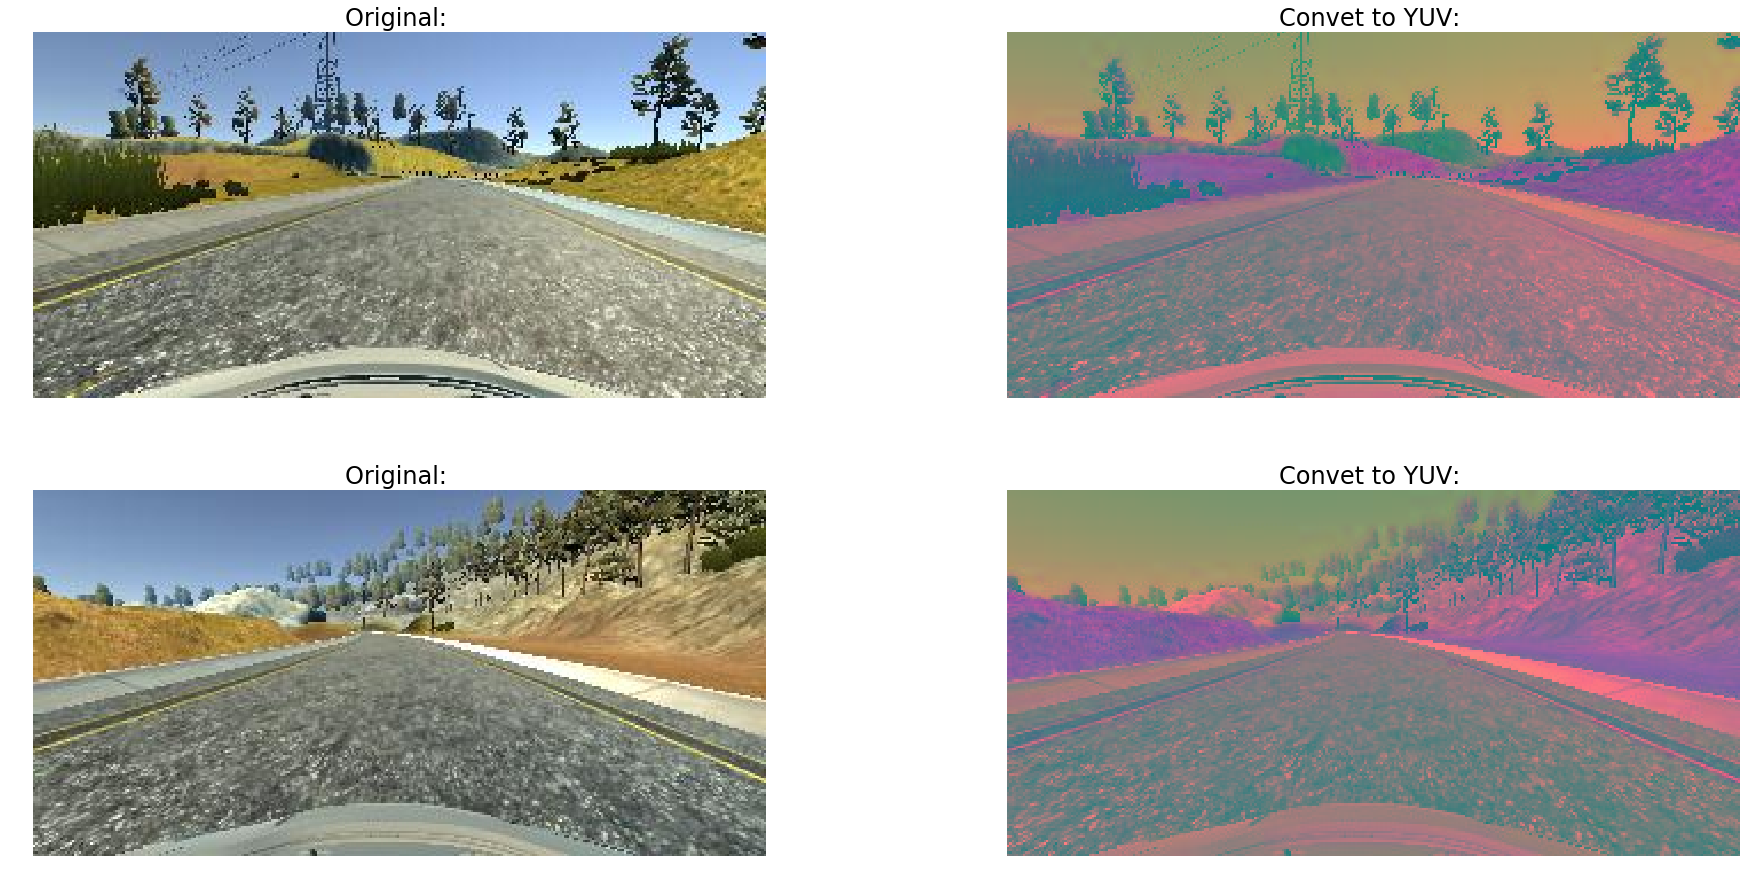

In [18]:
def plotConvert2YUV(samples):
    shuffle(samples)
    num_samples = len(samples)
    
    plt.figure(figsize=(32,32))
    plt.subplots_adjust(hspace=.25)
    for i in range(0, 4, 2):
        plot_index = random.randint(0, num_samples)
        sample = samples[plot_index]
        name = sample[0]
        angle = float(sample[3])
        image = mpimg.imread(name)
        
        plt.subplot(4,2,i+1)
        plt.title('Original: ', fontsize=24)
        plt.imshow(image)
        plt.axis('off')
        
        image1 = convert2YUV(image)
        plt.subplot(4,2,i+2)
        plt.title('Convet to YUV: ', fontsize=24)
        plt.imshow(image1)
        plt.axis('off')
    
plotConvert2YUV(samples)

In [19]:
set_batch_size = 64
def generator(samples, train_flag, batch_size=64):
    num_samples = len(samples)
    correction = 0.25 # correction angle used for the left and right images
    
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                name = batch_sample[0]
                center_image = mpimg.imread(name)
                center_angle = float(batch_sample[3])
                images.append(center_image)
                angles.append(center_angle)
                
                if train_flag:                   
                    # only add left and right images for training data (not for validation)
                    l_imagePath = batch_sample[1].replace(" ", "")
                    r_imagePath = batch_sample[2].replace(" ", "")
                    l_image = mpimg.imread(l_imagePath)
                    r_image = mpimg.imread(r_imagePath)

                    images.append(l_image)
                    angles.append(center_angle + correction)
                    images.append(r_image)
                    angles.append(center_angle - correction)
                    
                    # only add trans images for training data (not for validation)                           
                    tr_image, tr_angle= trans_image(center_image,center_angle,50,0)
                    images.append(tr_image)
                    angles.append(tr_angle)
                                       

            # flip image and change the brightness, for each input image, returns other 3 augmented images
            augmented_images, augmented_angles = data_augmentation(images, angles)
            
#             print("augmented_images shape: ", len(augmented_images))
#             print("augmented_angles shape: ", len(augmented_angles))
            
            X_train = np.array(augmented_images)
            y_train = np.array(augmented_angles)
            
#             print("X_train: ", X_train)
#             print("y_train: ", y_train)
            yield shuffle(X_train, y_train)

# compile and train the model using the generator function
train_generator = generator(train_samples, train_flag=True, batch_size=set_batch_size)
validation_generator = generator(validation_samples, train_flag=False, batch_size=set_batch_size)

### Train Model 1

In [20]:
new_size_col = 200
new_size_row = 66

# NVIDIA Model
# https://www.researchgate.net/profile/Mathew_Monfort/publication/301648615_End_to_End_Learning_for_Self-Driving_Cars/links/57b72f7308aec9984ff2a1ad/End-to-End-Learning-for-Self-Driving-Cars.pdf

model = Sequential()

model.add(Lambda(lambda x: x / 127.5 - 1, input_shape=(new_size_row,new_size_col,3), name='input'))

# Color space conversion layer, credit to Vivek's model
# model.add(Conv2D(3, (1, 1), padding='same', name='color_conv'))

model.add(Conv2D(24, (5, 5), padding="valid", activation='relu', name='conv1', kernel_regularizer=l2(0.001), strides=(2, 2)))

model.add(Conv2D(36, (5, 5), padding="valid", activation='relu', name='conv2', kernel_regularizer=l2(0.001), strides=(2, 2)))

model.add(Conv2D(48, (5, 5), padding="valid", activation='relu', name='conv3', kernel_regularizer=l2(0.001), strides=(2, 2)))

model.add(Conv2D(64, (3, 3), padding="valid", activation='relu', name='conv4', kernel_regularizer=l2(0.001)))

model.add(Conv2D(64, (3, 3), padding="valid", activation='relu', name='conv5', kernel_regularizer=l2(0.001)))

model.add(Flatten())
model.add(Dropout(0.2))

model.add(Dense(100, name='dense1'))

model.add(Dense(20, name='dense2'))

model.add(Dense(1, name='output'))

adam = Adam(lr=0.0001)

model.compile(optimizer= adam, loss="mean_squared_error", metrics=['accuracy'])

model.summary()

SVG(model_to_dot(model, show_shapes = True).create(prog='dot', format='svg'))

plot_model(model, show_shapes = True, to_file='model1.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Lambda)               (None, 66, 200, 3)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 47, 36)        21636     
_________________________________________________________________
conv3 (Conv2D)               (None, 5, 22, 48)         43248     
_________________________________________________________________
conv4 (Conv2D)               (None, 3, 20, 64)         27712     
_________________________________________________________________
conv5 (Conv2D)               (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
__________

In [21]:
# Train model in Keras 2 API
set_batch_size = 64
myepochs = 20
 
checkpointer = ModelCheckpoint(filepath="./tmp1/result1.{epoch:02d}-{val_loss:.4f}.hdf5", verbose=1, save_best_only=False)
    
model.fit_generator(train_generator, 
                    steps_per_epoch=len(train_samples)//set_batch_size, 
                    epochs=myepochs,
                    validation_data=validation_generator,
                    validation_steps=len(validation_samples)//set_batch_size,
                    callbacks=[checkpointer])

Epoch 1/20
48/48 [==============================] - 49s - loss: 0.2742 - acc: 0.0030 - val_loss: 0.2200 - val_acc: 0.0163
Epoch 2/20
48/48 [==============================] - 31s - loss: 0.2263 - acc: 0.0030 - val_loss: 0.1966 - val_acc: 0.0163
Epoch 3/20
48/48 [==============================] - 33s - loss: 0.2046 - acc: 0.0029 - val_loss: 0.1797 - val_acc: 0.0164
Epoch 4/20
48/48 [==============================] - 34s - loss: 0.1875 - acc: 0.0030 - val_loss: 0.1671 - val_acc: 0.0164
Epoch 5/20
48/48 [==============================] - 33s - loss: 0.1758 - acc: 0.0028 - val_loss: 0.1549 - val_acc: 0.0164
Epoch 6/20
48/48 [==============================] - 33s - loss: 0.1641 - acc: 0.0030 - val_loss: 0.1460 - val_acc: 0.0164
Epoch 7/20
48/48 [==============================] - 33s - loss: 0.1559 - acc: 0.0030 - val_loss: 0.1387 - val_acc: 0.0164
Epoch 8/20
48/48 [==============================] - 33s - loss: 0.1479 - acc: 0.0031 - val_loss: 0.1332 - val_acc: 0.0164
Epoch 9/20
48/48 [======

In [22]:
from keras.models import model_from_json

model_json = model.to_json()
with open("model1.json", "w") as json_file:
    json_file.write(model_json)
    
model.save_weights("model1.h5")
print("Saved model1 to disk")

Saved model1 to disk


### Train Model 2

In [23]:
new_size_col = 200
new_size_row = 66

input_shape = (new_size_row, new_size_col, 3)
"""
    Creates the comma.ai model, and returns a reference to the model
    The comma.ai model's original source code is available at:
    https://github.com/commaai/research/blob/master/train_steering_model.py
"""

model = Sequential()
model.add(Lambda(lambda x: x/127.5-1, input_shape=input_shape, name='input'))

# model.add(Conv2D(16, (8, 8), padding='same', activation='relu', strides=(4, 4), name='conv1'))
model.add(Conv2D(16, (5, 5), padding='same', activation='relu', strides=(4, 4), name='conv1'))

model.add(Conv2D(32, (5, 5), padding='same', activation='relu', strides=(2, 2), name='conv2'))

model.add(Conv2D(64, (5, 5), padding='same', activation='relu', strides=(2, 2), name='conv3'))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu', strides=(2, 2), name='conv4'))

model.add(Flatten())

model.add(Dropout(0.1))

model.add(Dense(512, name='dense1'))

model.add(Dense(64, name='dense2'))

model.add(Dense(1, name='output'))

adam = Adam(lr=0.0001)

model.compile(loss='mse', optimizer=adam)
model.summary()

SVG(model_to_dot(model, show_shapes = True).create(prog='dot', format='svg'))
plot_model(model, show_shapes = True, to_file='model2.png')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Lambda)               (None, 66, 200, 3)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 17, 50, 16)        1216      
_________________________________________________________________
conv2 (Conv2D)               (None, 9, 25, 32)         12832     
_________________________________________________________________
conv3 (Conv2D)               (None, 5, 13, 64)         51264     
_________________________________________________________________
conv4 (Conv2D)               (None, 3, 7, 128)         73856     
_________________________________________________________________
flatten_2 (Flatten)          (None, 2688)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2688)              0         
__________

In [24]:
# Train model in Keras 2 API
set_batch_size = 64
myepochs = 10
 
checkpointer = ModelCheckpoint(filepath="./tmp2/result2.{epoch:02d}-{val_loss:.4f}.hdf5", verbose=1, save_best_only=False)
    
model.fit_generator(train_generator, 
                    steps_per_epoch=len(train_samples)//set_batch_size, 
                    epochs=myepochs,
                    validation_data=validation_generator,
                    validation_steps=len(validation_samples)//set_batch_size,
                    callbacks=[checkpointer])

Epoch 1/10
48/48 [==============================] - 36s - loss: 0.0894 - val_loss: 0.0476
Epoch 2/10
48/48 [==============================] - 32s - loss: 0.0580 - val_loss: 0.0387
Epoch 3/10
48/48 [==============================] - 32s - loss: 0.0480 - val_loss: 0.0358
Epoch 4/10
48/48 [==============================] - 32s - loss: 0.0440 - val_loss: 0.0340
Epoch 5/10
48/48 [==============================] - 32s - loss: 0.0417 - val_loss: 0.0334
Epoch 6/10
48/48 [==============================] - 33s - loss: 0.0400 - val_loss: 0.0326
Epoch 7/10
48/48 [==============================] - 32s - loss: 0.0389 - val_loss: 0.0328
Epoch 8/10
48/48 [==============================] - 32s - loss: 0.0381 - val_loss: 0.0322
Epoch 9/10
48/48 [==============================] - 32s - loss: 0.0373 - val_loss: 0.0323
Epoch 10/10
48/48 [==============================] - 32s - loss: 0.0365 - val_loss: 0.0319


In [25]:
from keras.models import model_from_json

model_json = model.to_json()
with open("model2.json", "w") as json_file:
    json_file.write(model_json)
    
model.save_weights("model2.h5")
print("Saved model2 to disk")

Saved model2 to disk


### Train model 3

In [26]:
set_batch_size = 32
# compile and train the model using the generator function
train_generator = generator(train_samples, train_flag=True, batch_size=set_batch_size)
validation_generator = generator(validation_samples, train_flag=False, batch_size=set_batch_size)

In [27]:
new_size_col = 200
new_size_row = 66

"""
VGG net - with configuration A
:return: designed network model
https://arxiv.org/pdf/1409.1556.pdf
"""
model = Sequential()
model.add(Lambda(lambda x: x / 127.5 - 1., input_shape=(new_size_row,new_size_col,3), name='input'))
model.add(Conv2D(32,(3,3), activation='relu', name='conv1'))
model.add(MaxPooling2D())
model.add(Dropout(0.1))
model.add(Conv2D(64,(3,3), activation='relu', name='conv2'))
model.add(MaxPooling2D())
model.add(Dropout(0.1))
model.add(Conv2D(128,(3,3), activation='relu', name='conv3'))
model.add(MaxPooling2D())
model.add(Conv2D(256,(3,3), activation='relu', name='conv4'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(120, name='dense1'))
model.add(Dense(20, name='dense2'))
model.add(Dense(1, name='output'))

model.compile(loss='mse', optimizer='adam')
model.summary()

SVG(model_to_dot(model, show_shapes = True).create(prog='dot', format='svg'))
plot_model(model, show_shapes = True, to_file='model3.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Lambda)               (None, 66, 200, 3)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 198, 32)       896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 99, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 99, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 48, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 48, 64)        0         
__________

In [28]:
# Train model in Keras 2 API
set_batch_size = 32
myepochs = 20
 
checkpointer = ModelCheckpoint(filepath="./tmp3/result3.{epoch:02d}-{val_loss:.4f}.hdf5", verbose=1, save_best_only=False)
    
model.fit_generator(train_generator, 
                    steps_per_epoch=len(train_samples)//set_batch_size, 
                    epochs=myepochs,
                    validation_data=validation_generator,
                    validation_steps=len(validation_samples)//set_batch_size,
                    callbacks=[checkpointer])

Epoch 1/20
96/96 [==============================] - 89s - loss: 0.1532 - val_loss: 0.0388
Epoch 2/20
96/96 [==============================] - 88s - loss: 0.0517 - val_loss: 0.0346
Epoch 3/20
96/96 [==============================] - 84s - loss: 0.0467 - val_loss: 0.0355
Epoch 4/20
96/96 [==============================] - 84s - loss: 0.0445 - val_loss: 0.0364
Epoch 5/20
96/96 [==============================] - 84s - loss: 0.0433 - val_loss: 0.0343
Epoch 6/20
96/96 [==============================] - 84s - loss: 0.0424 - val_loss: 0.0322
Epoch 7/20
96/96 [==============================] - 84s - loss: 0.0413 - val_loss: 0.0317
Epoch 8/20
96/96 [==============================] - 84s - loss: 0.0408 - val_loss: 0.0317
Epoch 9/20
96/96 [==============================] - 84s - loss: 0.0403 - val_loss: 0.0303
Epoch 10/20
96/96 [==============================] - 84s - loss: 0.0401 - val_loss: 0.0307
Epoch 11/20
96/96 [==============================] - 84s - loss: 0.0391 - val_loss: 0.0307
Epoch 12

In [29]:
from keras.models import model_from_json

model_json = model.to_json()
with open("model3.json", "w") as json_file:
    json_file.write(model_json)
    
model.save_weights("model3.h5")
print("Saved model3 to disk")

Saved model3 to disk


In [ ]:
del model
# gc.collect()
from keras import backend as K
K.clear_session()